# 소상공인시장진흥공단 상가업소정보로 스타벅스, 이디야 위치 분석하기

* 이디야는 스타벅스 근처에 입점한다는 설이 있습니다. 과연 이디야와 스타벅스의 매장입지는 얼마나 차이가 날까요? 관련 기사를 읽고 구별로 이디야와 스타벅스의 매장을 기사와 유사하게 분석하고 시각화 해보면서 Python, Pandas, Numpy, Seaborn, Matplotlib 에 익숙해져 봅니다.

## 다루는 내용
* 공공데이터를 활용해 텍스트 데이터 정제하고 원하는 정보 찾아내기
* 문자열에서 원하는 텍스트 추출하기
* 문자열을 활용한 다양한 분석 방법과 위치 정보 사용하기
* folium을 통한 위경도 데이터 시각화 이해하기

## 실습
* 텍스트 데이터 정제하기 -  대소문자로 섞여있는 상호명을 소문자로 변경하고 상호명 추출하기
* 텍스트 데이터에서 원하는 정보 추출하기 - 브랜드명 컬럼을 만들고 구별 매장 수 분석하기
* folium을 통해 지도에 분석한 내용을 표현하기


## 데이터셋
* https://www.data.go.kr/dataset/15012005/fileData.do
* 구별로 매장수를 표현하기 위해 GeoJSON 파일 로드
    * 파일출처 : [southkorea/seoul-maps: Seoul administrative divisions in ESRI Shapefile, GeoJSON and TopoJSON formats.](https://github.com/southkorea/seoul-maps)
    * 이 링크에서도 다운로드가 가능합니다. https://drive.google.com/open?id=13j8-_XLdPe0pptsqu8-uyE-0Ym6V2jw5

## 관련기사
* [[비즈&빅데이터]스타벅스 '쏠림' vs 이디야 '분산'](http://news.bizwatch.co.kr/article/consumer/2018/01/19/0015)

In [1]:
# Window에서는 dir을 사용합니다.
# 파일의 목록을 확인할 수 있습니다.

%ls data

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 8E32-2172

 C:\Users\SWH\Desktop\Python\data 디렉터리

2020-03-04  오후 01:29    <DIR>          .
2020-03-04  오후 01:29    <DIR>          ..
2020-03-03  오후 07:27               299 covid_korea.csv
2020-03-03  오후 07:26            10,448 covid_korea.xlsx
2020-03-02  오후 10:09               326 lethal.csv
2020-03-02  오후 10:07               329 Lethality.csv
2020-03-04  오후 01:29           214,003 patient.csv
2020-03-04  오후 01:29             4,514 route.csv
2020-02-27  오후 01:52            57,732 seoul_municipalities_geo_simple.json
2020-02-27  오후 02:00       304,982,279 store_201906_01.csv
2020-03-04  오후 01:29             1,995 time.csv
2020-03-01  오후 08:56               906 virus_data.csv
2020-03-02  오후 08:38               798 사망자정보.csv
2020-03-01  오후 09:19            11,113 사망자정보.xlsx
2020-02-20  오후 04:08             2,163 전국 평균 분양가격(2013년 9월부터 2015년 8월까지).csv
2020-02-20  오후 04:08           149,663 주택도시보증공사_전국 평균 분양가격(2019년 8월)_20190917.csv
              14개 파일  

In [2]:
# warning 메시지 제거, warning 메시지는 라이브러리 업데이트나 사용법에 대한 안내 등이 있습니다.
# 코딩을 처음 시작할 때는  warning 메시지가 나오면 당황하실 수도 있어서 제거를 하고 보도록 합니다.
# warning 메시지는 제거하고 보셔도 되지만 Error 메시지를 꼭 고쳐주셔야 합니다.

import warnings
warnings.filterwarnings("ignore")

## 필요한 라이브러리 불러오기

In [3]:
# 판다스, 넘파이, 씨본을 불러옵니다.
import pandas as pd
import numpy as np
import seaborn as sns

# 구버전의 주피터 노트북에서 그래프가 보이는 설정
%matplotlib inline

## 시각화를 위한 한글 폰트 설정하기

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)

## Colab 에서 실행을 위한 코드

* 아래의 코드는 google colaboratory 에서 실행을 위한 코드로 로컬 아나콘다에서는 주석처리합니다.
* google colaboratory 에서는 주석을 풀고 폰트 설정과 csv 파일을 불러옵니다.

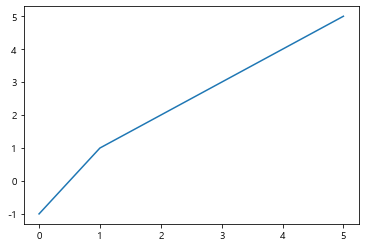

In [5]:
# 설정 후 -1값이 깨지지 않음
pd.Series([-1, 1, 2, 3, 4, 5]).plot()

In [6]:
# # 나눔고딕 설치
# !apt -qq -y install fonts-nanum > /dev/null

# import matplotlib.font_manager as fm

# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# font = fm.FontProperties(fname=fontpath, size=9)
# fm._rebuild()

# # 그래프에 retina display 적용
# %config InlineBackend.figure_format = 'retina'

# # Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumBarunGothic') 

## Colab 용 GoogleAuth 인증 
* 구글 드라이브에 있는 파일을 가져오기 위해 사용합니다.

In [7]:
# # 구글 드라이브에서 csv 파일을 읽어오기 위해 gauth 인증
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # PyDrive client 인증
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [8]:
# # 공유 가능한 링크로 파일 가져오기
# url = 'https://drive.google.com/open?id=1xvJs9ZxUHoBBAUXq1IWEaRXgcop8KjrT'
# id = url.split('=')[1]
# print(id)
# downloaded = drive.CreateFile({'id':id}) 
# # data 폴더에 파일을 관리하며, 폴더가 없다면 만들어서 파일을 관리하도록 한다.
# %mkdir data
# downloaded.GetContentFile('data/store_201906_01.csv')  

## 데이터 불러오기
* 데이터 다운로드 위치 : https://www.data.go.kr/dataset/15012005/fileData.do
* 공공데이터 포털에서 소상공인시장진흥공단 상가업소정보를 다운로드 받아 사용했습니다.
* 구글드라이브에서 받기 : https://drive.google.com/open?id=1xvJs9ZxUHoBBAUXq1IWEaRXgcop8KjrT

In [9]:
# 파일을 불러와 df_store 라는 변수에 담습니다.

df_store = pd.read_csv('data/store_201906_01.csv')

## 데이터 크기 보기

In [10]:
# shape 를 통해 불러온 csv 파일의 크기를 확인합니다.
df_store.shape

(565016, 39)

## info 보기

In [11]:
# info 를 사용하면 데이터의 전체적인 정보를 볼 수 있습니다.
# 데이터의 사이즈, 타입, 메모리 사용량 등을 볼 수 있습니다.
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565016 entries, 0 to 565015
Data columns (total 39 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   상가업소번호     565016 non-null  int64  
 1   상호명        565015 non-null  object 
 2   지점명        75524 non-null   object 
 3   상권업종대분류코드  565016 non-null  object 
 4   상권업종대분류명   565016 non-null  object 
 5   상권업종중분류코드  565016 non-null  object 
 6   상권업종중분류명   565016 non-null  object 
 7   상권업종소분류코드  565016 non-null  object 
 8   상권업종소분류명   565016 non-null  object 
 9   표준산업분류코드   532064 non-null  object 
 10  표준산업분류명    532064 non-null  object 
 11  시도코드       565016 non-null  int64  
 12  시도명        565016 non-null  object 
 13  시군구코드      565016 non-null  int64  
 14  시군구명       565016 non-null  object 
 15  행정동코드      565016 non-null  int64  
 16  행정동명       565016 non-null  object 
 17  법정동코드      565016 non-null  int64  
 18  법정동명       565016 non-null  object 
 19  지번코드       565016 non-n

## 결측치 보기

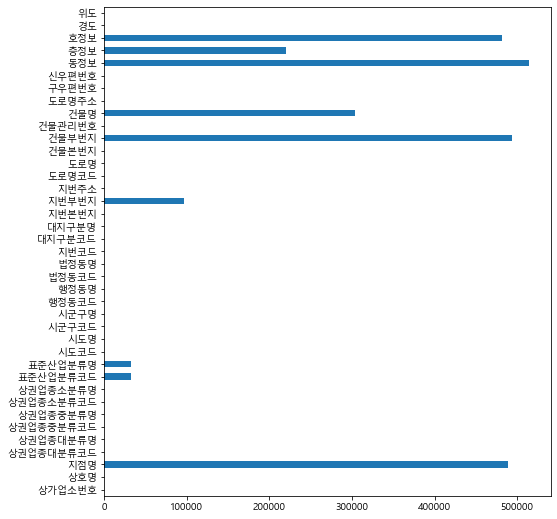

In [12]:
# isnull() 을 사용하면 데이터의 결측치를 볼 수 있습니다.
# 결측치는 True로 값이 있다면 False로 표시되는데 True 는 1과 같기 때문에 
# True 값을 sum()을 사용해서 더하게 되면 합계를 볼 수 있습니다.

# df_store.isnull().sum().plot.barh(figsize=(8,9))
df_store.isnull().sum().plot.barh(figsize=(8,9))

## 사용하지 않는 컬럼 제거하기

In [13]:
# 사용할 컬럼만 따로 불러와서 작업을 할 수도 있지만 사용하지 않는 컬럼을 제거하는 방법도 있습니다.
# 판다스에서는 drop 기능을 사용해서 사용하지 않는 컬럼을 삭제할 수 있습니다.
# 삭제할 컬럼을 drop_columns 라는 변수에 리스트 형태로 담아보도록 합니다.

# null_cols = df_store.isnull().sum().sort_values(ascending=False).head(9)
# drop_columns = null_cols.index.to_list()
# drop_columns

null_cols = df_store.isnull().sum().sort_values(ascending=False).head(9)
drop_columns = null_cols.index.to_list()
drop_columns

['동정보', '건물부번지', '지점명', '호정보', '건물명', '층정보', '지번부번지', '표준산업분류명', '표준산업분류코드']

In [14]:
# drop를 사용해 사용하지 않는 컬럼을 제거합니다.
# 컬럼을 제거하기 전과 제거 후에 shape 를 통해 컬럼의 수가 달라졌는지 확인합니다.
# print(df_store.shape)
print(df_store.shape)
# axis가 0이면 행을 기준으로함. 1이면 열을 기준으로함.
# df_store = df_store.drop(drop_columns, axis=1)
# print(df_store.shape)
df_store = df_store.drop(drop_columns, axis=1)
print(df_store.shape)

(565016, 39)
(565016, 30)


In [15]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565016 entries, 0 to 565015
Data columns (total 30 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   상가업소번호     565016 non-null  int64  
 1   상호명        565015 non-null  object 
 2   상권업종대분류코드  565016 non-null  object 
 3   상권업종대분류명   565016 non-null  object 
 4   상권업종중분류코드  565016 non-null  object 
 5   상권업종중분류명   565016 non-null  object 
 6   상권업종소분류코드  565016 non-null  object 
 7   상권업종소분류명   565016 non-null  object 
 8   시도코드       565016 non-null  int64  
 9   시도명        565016 non-null  object 
 10  시군구코드      565016 non-null  int64  
 11  시군구명       565016 non-null  object 
 12  행정동코드      565016 non-null  int64  
 13  행정동명       565016 non-null  object 
 14  법정동코드      565016 non-null  int64  
 15  법정동명       565016 non-null  object 
 16  지번코드       565016 non-null  int64  
 17  대지구분코드     565016 non-null  int64  
 18  대지구분명      565016 non-null  object 
 19  지번본번지      565016 non-n

## 일부 컬럼만 보기

In [16]:
# '상권업종대분류명'만 가지고 옵니다.

df_store['상권업종대분류명']

0            음식
1            음식
2            음식
3            음식
4         생활서비스
          ...  
565011       음식
565012       음식
565013    학문/교육
565014       소매
565015       소매
Name: 상권업종대분류명, Length: 565016, dtype: object

In [17]:
# '상권업종소분류명'만 가지고 옵니다.

df_store['상권업종소분류명']

0         커피전문점/카페/다방
1               호프/맥주
2               토스트전문
3               호프/맥주
4          사우나/증기탕/온천
             ...     
565011       중국음식/중국집
565012       중국음식/중국집
565013            독서실
565014          전화기판매
565015          전화기판매
Name: 상권업종소분류명, Length: 565016, dtype: object

In [18]:
# '상권업종대분류명', '상권업종소분류명' 두 개의 컬럼을 가져옵니다.
# 2개 이상의 컬럼을 가져올 때는 리스트 형태의 데이터로 묶어서 사용해야 합니다.

# df_store[['상권업종대분류명','상권업종소분류명']].head()
df_store[['상권업종대분류명','상권업종소분류명']].head(2)

,상권업종대분류명,상권업종소분류명
0,음식,커피전문점/카페/다방
1,음식,호프/맥주


In [19]:
# columns 를 사용하면 데이터프레임의 컬럼명만 가져옵니다.

df_store.columns

Index(['상가업소번호', '상호명', '상권업종대분류코드', '상권업종대분류명', '상권업종중분류코드', '상권업종중분류명',
       '상권업종소분류코드', '상권업종소분류명', '시도코드', '시도명', '시군구코드', '시군구명', '행정동코드',
       '행정동명', '법정동코드', '법정동명', '지번코드', '대지구분코드', '대지구분명', '지번본번지', '지번주소',
       '도로명코드', '도로명', '건물본번지', '건물관리번호', '도로명주소', '구우편번호', '신우편번호', '경도',
       '위도'],
      dtype='object')

In [20]:
# 컬럼이 많은 편입니다. 모든 컬럼을 다 사용하지 않기 때문에 일부 컬럼만 가져옵니다.
df_columns = ['상가업소번호', '상호명', '상권업종대분류명', 
       '상권업종중분류명',  '상권업종소분류명', '시도코드',
       '시도명', '시군구코드', '시군구명', '행정동명', '법정동명', '지번코드',
       '대지구분명', '지번본번지','지번주소', '도로명주소', 
       '구우편번호', '신우편번호', '경도', '위도']
df = df_store[df_columns].copy()
df.shape

(565016, 20)

## 일부 텍스트가 들어가는 데이터만 가져오기

In [21]:
# str.contains를 사용하면 특정 단어가 포함된 데이터를 가져옵니다.
# 여기에서는 '상권업종소분류명'으로 '커피'가 들어가는 단어만 가져옵니다.
df_coffee = df[df['상권업종소분류명'].str.contains('커피')]
df_coffee.head(2)

,상가업소번호,상호명,상권업종대분류명,상권업종중분류명,상권업종소분류명,시도코드,시도명,시군구코드,시군구명,행정동명,법정동명,지번코드,대지구분명,지번본번지,지번주소,도로명주소,구우편번호,신우편번호,경도,위도
0,19911397,커피빈코리아선릉로93길점,음식,커피점/카페,커피전문점/카페/다방,11,서울특별시,11680,강남구,역삼1동,역삼동,1168010100206960042,대지,696,서울특별시 강남구 역삼동 696-42,서울특별시 강남구 선릉로93길 6,135080,6149.0,127.047883,37.505675
10,20020124,스완카페트,음식,커피점/카페,커피전문점/카페/다방,11,서울특별시,11560,영등포구,대림3동,대림동,1156013300206040056,대지,604,서울특별시 영등포구 대림동 604-56,서울특별시 영등포구 도신로10가길 11-1,150070,7379.0,126.897710,37.503693


In [22]:
df_coffee['상호명']

0         커피빈코리아선릉로93길점
10                스완카페트
16                   왕실
20                  커피빈
22         고려대학교교육관쎄리오점
              ...      
564967           투썸플레이스
564968            놀러오시개
564969             뉴욕보틀
564970        블루빈로스터스커피
564971           심리카페멘토
Name: 상호명, Length: 23103, dtype: object

In [23]:
# 상호명으로 봤을 때 커피점의 수를 출력해 봅니다.
# unique 를 사용하면 중복을 제거한 상호명을 가져옵니다. 
# 그리고 shape로 갯수를 출력해 봅니다.
df_coffee['상호명'].unique()

array(['커피빈코리아선릉로93길점', '스완카페트', '왕실', ..., '놀러오시개', '뉴욕보틀', '블루빈로스터스커피'],
      dtype=object)

In [24]:
# nunique 를 사용하면 중복을 제거한 상호명의 갯수를 세어줍니다.

df_coffee['상호명'].nunique()

15205

In [25]:
# 중복을 제거한 스타벅스의 상호명만 가져옵니다.
# 스타벅스라는 브랜드명을 어떻게 추출해야 할지 알아보기 위함입니다.
# df_coffee.loc[df_coffee['상호명'].str.contains('스타벅스|STARBUCKS'),'상호명']
df_coffee.loc[df_coffee['상호명'].str.contains('스타벅스|STARBUCKS'),'상호명']

1219                스타벅스
1946           스타벅스종로3가점
2840                스타벅스
14939     스타벅스커피여의도IFC1F
14951               스타벅스
               ...      
562067              스타벅스
562068              스타벅스
562381              스타벅스
563162              스타벅스
564740              스타벅스
Name: 상호명, Length: 602, dtype: object

## 시도별 데이터 보기
* 시도와 구군 데이터가 있습니다. 어느 시도의 데이터가 있는지 봅니다.

In [26]:
# 시도에 결측치가 있는지 다시 봅니다.

df['시도명'].isnull().sum()

0

In [27]:
# 지난 데이터와 마찬가지로 서울과 부산만 있습니다.
# 다른 지역을 참고하고 싶다면 다운로드 받은 공공데이터와 같은 폴더에 있는 다른 파일을 참고해 주세요.
df['시도명'].value_counts()

서울특별시    401071
부산광역시    163945
Name: 시도명, dtype: int64

In [28]:
# 시군구명에서 unique 한 값을 봅니다.

df['시군구명'].unique()

array(['강남구', '금천구', '사상구', '송파구', '광진구', '강서구', '중구', '영등포구', '서대문구',
       '동대문구', '서초구', '성북구', '구로구', '노원구', '동래구', '부산진구', '동작구', '동구',
       '수영구', '성동구', '영도구', '관악구', '강동구', '종로구', '양천구', '해운대구', '금정구',
       '연제구', '은평구', '기장군', '강북구', '사하구', '마포구', '중랑구', '서구', '도봉구', '북구',
       '남구', '용산구'], dtype=object)

In [29]:
# coffee 라고 만들어 준 데이터 프레임을 통해 "상권업종중분류명"을 value_counts()로 요약해 봅니다.

df_coffee['상권업종중분류명'].value_counts()

커피점/카페    23103
Name: 상권업종중분류명, dtype: int64

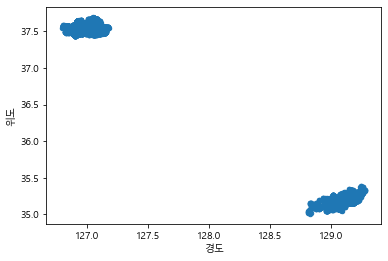

In [30]:
# 경도와 위도가 있습니다. 데이터를 그려봅니다.

df_coffee[['경도','위도']].plot.scatter(x='경도',y='위도')

## 서울만 따로 보기

In [31]:
# 시도명이 서울로 시작하는 데이터만 봅니다.
# 또, df_seoul 이라는 변수에 결과를 저장합니다.
# 새로운 변수에 데이터프레임을 할당할 때 copy()를 사용하는 것을 권장합니다.
df_seoul = df[df['시도명'] == '서울특별시'].copy()
df_seoul.shape

(401071, 20)

In [32]:
# 서울 데이터의 결측치를 봅니다. 위와 동일하게 isnull() 과 sum() 을 사용해서 결측치의 수를 더할 수 있습니다.
df_seoul.isnull().sum()

상가업소번호      0
상호명         0
상권업종대분류명    0
상권업종중분류명    0
상권업종소분류명    0
시도코드        0
시도명         0
시군구코드       0
시군구명        0
행정동명        0
법정동명        0
지번코드        0
대지구분명       0
지번본번지       0
지번주소        0
도로명주소       0
구우편번호       0
신우편번호       2
경도          0
위도          0
dtype: int64

In [33]:
# 서울에 있는 '상권업종대분류명'을 그룹화 하여 갯수를 세어봅니다.
df_seoul['상권업종대분류명'].value_counts()

음식          131687
소매          124782
생활서비스        64344
학문/교육        31247
의료           18826
부동산          15430
관광/여가/오락     11578
숙박            3047
스포츠            130
Name: 상권업종대분류명, dtype: int64

In [34]:
# describe 를 하게 되면 요약된 데이터 정보를 볼 수 있습니다.
df_seoul.describe()

,상가업소번호,시도코드,시군구코드,지번코드,지번본번지,구우편번호,신우편번호,경도,위도
count,4.010710e+05,401071.0,401071.000000,4.010710e+05,401071.000000,401071.000000,401069.000000,401071.000000,401071.000000
mean,2.052282e+07,11.0,11442.252968,1.144238e+18,409.462442,136291.790244,5175.680167,126.996983,37.544965
std,5.322704e+06,0.0,200.674978,2.006699e+16,412.802944,14225.510291,2099.935420,0.080574,0.048108
min,2.890524e+06,11.0,11110.000000,1.111010e+18,1.000000,100011.000000,1000.000000,126.768169,37.434081
25%,1.601555e+07,11.0,11230.000000,1.123071e+18,89.000000,131200.000000,3414.000000,126.928061,37.505431
50%,2.237100e+07,11.0,11470.000000,1.147010e+18,289.000000,136801.000000,5242.000000,127.012732,37.541162
75%,2.493524e+07,11.0,11650.000000,1.165010e+18,635.000000,143848.000000,6716.000000,127.057331,37.571921
max,2.852486e+07,11.0,11740.000000,1.174070e+18,9994.000000,158885.000000,8866.000000,127.182588,37.692398


In [35]:
# 위도와 경도만 describe 를 통해 요약해 봅니다.
df_seoul[['위도','경도']].describe()

,위도,경도
count,401071.000000,401071.000000
mean,37.544965,126.996983
std,0.048108,0.080574
min,37.434081,126.768169
25%,37.505431,126.928061
50%,37.541162,127.012732
75%,37.571921,127.057331
max,37.692398,127.182588


### 분류별 countplot 그리기

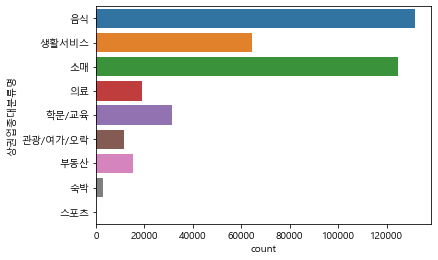

In [36]:
# 상권업종대분류명 으로 seaborn 의 countplot 을 사용해 시각화를 합니다.
# seaborn 의 countplot는 같은 데이터를 그룹화하여 더해준 값을 그래프로 표현합니다.
sns.countplot(data=df_seoul, y='상권업종대분류명')

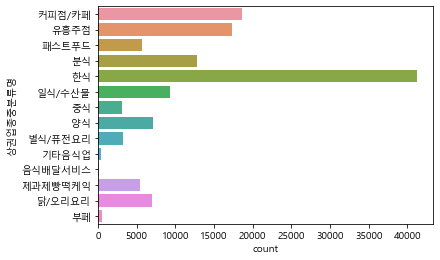

In [37]:
# "상권업종대분류명"을 시각화하면 "음식" 업종이 가장 많습니다.

df_food = df_seoul[df_seoul['상권업종대분류명'] == '음식']

sns.countplot(data=df_food, y='상권업종중분류명')

In [38]:
# countplot 을 그리면 해당 카테코리에 해당되는 데이터의 수를 카운트해서 시각화 합니다.

df_food['상권업종중분류명'].value_counts()

한식         41243
커피점/카페     18651
유흥주점       17299
분식         12787
일식/수산물      9282
양식          7094
닭/오리요리      6958
패스트푸드       5683
제과제빵떡케익     5380
별식/퓨전요리     3263
중식          3117
부페           494
기타음식업        339
음식배달서비스       97
Name: 상권업종중분류명, dtype: int64

## 특정 업종만 가져오기

In [39]:
# 특정 업종만 가져오고 싶다면 "패스트푸드" 만 보도록 합니다.

df_fast_food = df_food.loc[df_food['상권업종중분류명'] == '패스트푸드']
df_fast_food.head(2)

,상가업소번호,상호명,상권업종대분류명,상권업종중분류명,상권업종소분류명,시도코드,시도명,시군구코드,시군구명,행정동명,법정동명,지번코드,대지구분명,지번본번지,지번주소,도로명주소,구우편번호,신우편번호,경도,위도
5,19964615,석봉토스트,음식,패스트푸드,토스트전문,11,서울특별시,11215,광진구,구의2동,구의동,1121510300200770047,대지,77,서울특별시 광진구 구의동 77-47,서울특별시 광진구 자양로39길 20,143200,4992.0,127.088387,37.549245
7,19977290,피자마루,음식,패스트푸드,피자전문,11,서울특별시,11140,중구,약수동,신당동,1114016200203720095,대지,372,서울특별시 중구 신당동 372-95,서울특별시 중구 동호로7길 37,100450,4596.0,127.010861,37.552153


In [40]:
# 해당 데이터에서 특정 컬럼만 가져오고 싶은데 컬럼명이 생각나지 않는다면 컬럼명만 가져와 봅니다.

df_fast_food.columns

Index(['상가업소번호', '상호명', '상권업종대분류명', '상권업종중분류명', '상권업종소분류명', '시도코드', '시도명',
       '시군구코드', '시군구명', '행정동명', '법정동명', '지번코드', '대지구분명', '지번본번지', '지번주소',
       '도로명주소', '구우편번호', '신우편번호', '경도', '위도'],
      dtype='object')

In [41]:
# 상호명을 unique 로 출력해 봅니다.

df_fast_food['상호명'].unique()

array(['석봉토스트', '피자마루', '솔로몬피자', ..., '몬스터피자&펍', '피자뽀끼', '피자레볼루션'],
      dtype=object)

## 스타벅스, 이디야 위치 분석
* 상호명에서 브랜드명을 추출합니다.
* 대소문자가 섞여 있을 수도 있기 때문에 대소문자를 변환해 줍니다.
* 오타를 방지하기 위해 스타벅스의 영문명은 STARBUCKS, 이디야는 EDIYA 입니다.

In [42]:
# 문자열의 소문자로 변경하는 메소드를 사용합니다.
# "상호명_소문자" 컬럼을 만듭니다.
df_seoul['상호명_소문자'] = df_seoul['상호명'].str.lower()
df_seoul['상호명_소문자']

0         커피빈코리아선릉로93길점
1                  프로포즈
3                와라와라호프
4              가락사우나내스낵
5                 석봉토스트
              ...      
565003             호중정원
565006               꿀닭
565008       서초종합공사인테리어
565010            전설의짬뽕
565012               주방
Name: 상호명_소문자, Length: 401071, dtype: object

In [43]:
# ediya 를 "상호명_소문자" 컬럼으로 가져옵니다.
# loc[행]
# loc[행, 열]

# df_seoul.loc[df_seoul['상호명_소문자'].str.contains('이디야|이디아|ediya'),'상호명_소문자'].shape
df_seoul.loc[df_seoul['상호명_소문자'].str.contains('이디야|이디아|ediya'),'상호명_소문자'].shape

(539,)

In [44]:
# 상호명에서 스타벅스만 가져옵니다.
# 상호명은 소문자로 변경해 준 컬럼을 사용합니다.

# df_seoul.loc[df_seoul['상호명_소문자'].str.contains('스타벅스|starbucks'),'상호명_소문자'].shape
df_seoul.loc[df_seoul['상호명_소문자'].str.contains('스타벅스|starbucks'),'상호명_소문자'].shape

(502,)

In [45]:
# 스타벅스|starbucks 의 "상호명"으로 갯수를 세어봅니다.

df_seoul.loc[df_seoul['상호명'].str.contains('스타벅스|starbucks'),'상호명'].shape

(501,)

In [46]:
# '상호명_소문자'컬럼으로 '이디야|ediya' 를 가져와 갯수를 세어봅니다.

df_seoul.loc[df_seoul['상호명_소문자'].str.contains('이디야|ediya'),'상호명_소문자'].shape

(501,)

In [47]:
# '상호명_소문자'컬럼으로  '스타벅스|starbucks|이디야|ediya'를 가져와 df_cafe 변수에 담습니다.

df_cafe = df_seoul[
    df_seoul['상호명_소문자'].str.contains(
        '스타벅스|starbucks|이디야|이디아|ediya')].copy()
df_cafe.head(1)

,상가업소번호,상호명,상권업종대분류명,상권업종중분류명,상권업종소분류명,시도코드,시도명,시군구코드,시군구명,행정동명,...,지번코드,대지구분명,지번본번지,지번주소,도로명주소,구우편번호,신우편번호,경도,위도,상호명_소문자
1219,19976038,스타벅스,음식,커피점/카페,커피전문점/카페/다방,11,서울특별시,11170,용산구,이태원1동,...,1117013000201270006,대지,127,서울특별시 용산구 이태원동 127-6,서울특별시 용산구 이태원로 188,140200,4406.0,126.994781,37.534303,스타벅스


In [48]:
# ~은 not을 의미합니다. 스타벅스가 아닌 데이터는 이디야로 넣어주어도 되지만
# 아래 코드처럼 결측치를 이디야로 채워줘도 괜찮습니다.
# df_cafe.loc[~df_cafe['상호명'].str.contains('스타벅스|starbucks'), '브랜드명'] = '이디야'

df_cafe.loc[df_cafe['상호명_소문자'].str.contains('스타벅스|starbucks'), '브랜드명'] = '스타벅스'
df_cafe.loc[~df_cafe['상호명_소문자'].str.contains('스타벅스|starbucks'), '브랜드명'] = '이디야'
df_cafe.head(2)

,상가업소번호,상호명,상권업종대분류명,상권업종중분류명,상권업종소분류명,시도코드,시도명,시군구코드,시군구명,행정동명,...,대지구분명,지번본번지,지번주소,도로명주소,구우편번호,신우편번호,경도,위도,상호명_소문자,브랜드명
1219,19976038,스타벅스,음식,커피점/카페,커피전문점/카페/다방,11,서울특별시,11170,용산구,이태원1동,...,대지,127,서울특별시 용산구 이태원동 127-6,서울특별시 용산구 이태원로 188,140200,4406.0,126.994781,37.534303,스타벅스,스타벅스
1676,25435527,이디야커피,음식,커피점/카페,커피전문점/카페/다방,11,서울특별시,11560,영등포구,신길1동,...,대지,59,서울특별시 영등포구 신길동 59-2,서울특별시 영등포구 영등포로 353,150050,7318.0,126.918062,37.515118,이디야커피,이디야


In [49]:
# 스타벅스를 제외한 데이터는 이디야이기 때문에 이디야로 브랜드명을 만듭니다.
# df_cafe['브랜드명'].fillna('이디야')

In [50]:
# 브랜드명이 없는 데이터가 있는지 봅니다.
# 위에서 브랜드명을 이디야로 채워줬기 때문에 브랜드명이 모두 잘 채워졌는지 확인합니다.
# 확인을 위한 방법으로 isnull() 혹은 isna()를 사용합니다.
# isnull() 로 결측치 여부를 확인하면 True, False 로 표시가 됩니다.
# True == 1, False == 0 과 같기 때문에 이 값을 다 더하면 결측치의 수가 됩니다.

df_cafe['브랜드명'].isnull().sum()

0

In [51]:
# 혹시 채워지지 않은 값이 있다면 어떤 상호인지 확인하기 위해 결괏값에서 '상호명'만 가져오도록 합니다.

df_cafe['상호명'].unique()

array(['스타벅스', '이디야커피', '스타벅스종로3가점', '이디아', '스타벅스커피여의도IFC1F',
       '이디야IBK고객센터', '스타벅스신림사거리점', '대신이디아이서원주유소', '이디야서대문점2호',
       '스타벅스커피홍대역', '이디아커피', 'EDIYA커피', '스타벅스새문안로점', '스타벅스올림픽평화의문점',
       '스타벅스연신내역', '스타벅스연세백양로점', '스타벅스가락시장역점', '스타벅스외대점', '스타벅스석촌역',
       '스타벅스명지대점', '스타벅스압구정로데오역', '이디야커피전농뉴타운점', '스타벅스연대동문', '이디아이박정어학원',
       '스타벅스강남삼성타운점', '스타벅스사당점', '스타벅스신림점', '스타벅스서울대입구역점', '스타벅스광장점',
       '이디아커피선릉아이빌점', '스타벅스신촌명물거리점', '스타벅스명동미래', '스타벅스건국클래식점',
       '스타벅스연희DT점', '스타벅스삼선교점', '스타벅스종각점', '스타벅스올림픽공원북문점', '스타벅스커피여의도호성',
       '스타벅스충정타워', '스타벅스방배카페입구', '스타벅스이수역점', '이디야커피이대역점', '스타벅스W-MALL점',
       '스타벅스용산역점', '스타벅스마포일진빌딩점', '스타벅스천호로데오점', '스타벅스중계역점', '스타벅스명동메트로',
       '이디야커피자양동점', '스타벅스마포아크로타워점', '스타벅스남부터미널2점', '스타벅스구로디지털로점',
       '스타벅스중랑구청점', '이디야커피은행나무사거리점', '스타벅스종로관수점', '스타벅스논현힐탑',
       '스타벅스삼성도심공항점', '이디야커피마포KCC점', '스타벅스종로2가점', '스타벅스선정릉역점', '스타벅스선릉로점',
       '스타벅스명동역', '스타벅스미아역점', '이디아동묘역점', '스타벅스역삼럭키', '스타벅스커피신도림디큐브시티B2',
       '이디야커피천호현대점', '스타벅스이태원거리점',

In [52]:
# 브랜드명이 다 채워졌는지 확인하기 위해 결측치(비어있는 값)이 있는지 확인합니다.
# isna, isnull 로 확인을 할 수 있으며 sum()으로 갯수를 세어볼 수 있습니다.
df_cafe['브랜드명'].isna().sum()

0

In [53]:
# 'df_cafe에 담긴 상호명','브랜드명'으로 미리보기를 합니다.
df_cafe[['상호명','브랜드명']]

,상호명,브랜드명
1219,스타벅스,스타벅스
1676,이디야커피,이디야
1946,스타벅스종로3가점,스타벅스
2840,스타벅스,스타벅스
2886,이디야커피,이디야
...,...,...
562067,스타벅스,스타벅스
562068,스타벅스,스타벅스
562381,스타벅스,스타벅스
563162,스타벅스,스타벅스


In [54]:
# 브랜드명으로 각 카페의 갯수를 세어봅니다.

df_cafe['브랜드명'].value_counts()

이디야     539
스타벅스    502
Name: 브랜드명, dtype: int64

* https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#scatter-plot

In [55]:
df_cafe.loc[(df_cafe['상호명'].str.contains('이디아')) & (df_cafe['상권업종대분류명'].str.contains('음식')), '상호명']

13719              이디아
27810              이디아
35636              이디아
36714            이디아커피
55426              이디아
56336      이디아커피선릉아이빌점
64866              이디아
67183            이디아커피
79754            이디아커피
96858          이디아동묘역점
125008           이디아커피
127037        이디아에스프레소
161108        이디아역삼시장점
163588             이디아
166504         이디아커피역점
167132             이디아
171191        이디아에스프레소
287637           이디아커피
287788             이디아
314317             이디아
321600           이디아커피
323877         이디아신촌역점
329021           이디아커피
394409           이디아커피
399945       이디아신방화중앙점
420086           이디아커피
483136           이디아커피
498131             이디아
505855    이디아커피합정엘아이지점
507199        이디아커피세종대
Name: 상호명, dtype: object

In [56]:
df_cafe = df_cafe[df_cafe['상권업종대분류명'] == '음식'].copy()
df_cafe.shape

(1031, 22)

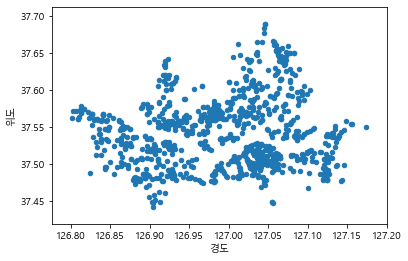

In [57]:
df_cafe[['위도','경도']].plot.scatter(x='경도',y='위도')

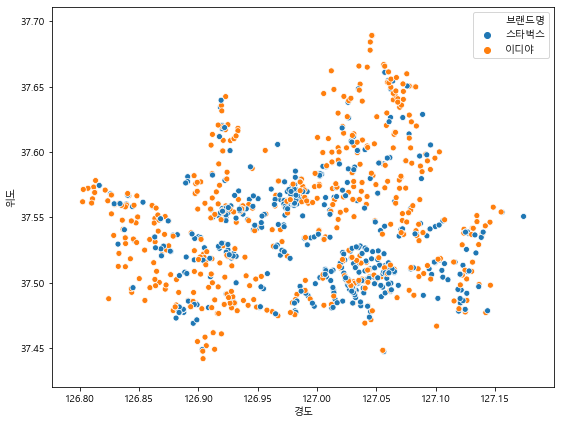

In [58]:
# seaborn의 scatterplot 으로 hue에 브랜드명을 지정해서 시각화 합니다.
plt.figure(figsize=(9,7))
sns.scatterplot(data=df_cafe, x='경도',y='위도', hue='브랜드명')

## 구별 브랜드별 점포수

In [59]:
df_cafe.pivot_table(columns='시군구명')

시군구명,강남구,강동구,강북구,강서구,관악구,광진구,구로구,금천구,노원구,도봉구,...,성동구,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구
경도,1.270457e+02,1.271354e+02,1.270229e+02,1.268379e+02,1.269356e+02,1.270833e+02,1.268775e+02,1.268922e+02,1.270672e+02,1.270405e+02,...,1.270384e+02,1.270263e+02,1.271142e+02,1.268620e+02,1.269137e+02,1.269825e+02,1.269204e+02,1.269872e+02,1.269866e+02,1.270873e+02
구우편번호,1.353792e+05,1.342417e+05,1.423483e+05,1.575091e+05,1.515842e+05,1.435887e+05,1.524867e+05,1.536880e+05,1.394601e+05,1.321886e+05,...,1.335797e+05,1.364117e+05,1.385537e+05,1.583562e+05,1.506161e+05,1.406206e+05,1.226124e+05,1.104266e+05,1.005626e+05,1.313025e+05
상가업소번호,1.920802e+07,2.005656e+07,1.822059e+07,1.705090e+07,1.921120e+07,2.030183e+07,1.895545e+07,1.882462e+07,1.804290e+07,1.893736e+07,...,1.927575e+07,2.029648e+07,1.833240e+07,1.926149e+07,1.841667e+07,1.757484e+07,1.881124e+07,1.987119e+07,1.926305e+07,1.934846e+07
시군구코드,1.168000e+04,1.174000e+04,1.130500e+04,1.150000e+04,1.162000e+04,1.121500e+04,1.153000e+04,1.154500e+04,1.135000e+04,1.132000e+04,...,1.120000e+04,1.129000e+04,1.171000e+04,1.147000e+04,1.156000e+04,1.117000e+04,1.138000e+04,1.111000e+04,1.114000e+04,1.126000e+04
시도코드,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,...,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01
신우편번호,6.162301e+03,5.328370e+03,1.116118e+03,7.671746e+03,8.766875e+03,5.024125e+03,8.306970e+03,8.553625e+03,1.773395e+03,1.376100e+03,...,4.747480e+03,2.795054e+03,5.676564e+03,7.991889e+03,7.304121e+03,4.371806e+03,3.380839e+03,3.119750e+03,4.547012e+03,2.125176e+03
위도,3.750598e+01,3.754032e+01,3.763115e+01,3.755597e+01,3.748169e+01,3.754377e+01,3.749406e+01,3.746929e+01,3.764239e+01,3.766577e+01,...,3.755509e+01,3.759906e+01,3.750108e+01,3.752892e+01,3.752073e+01,3.753469e+01,3.761407e+01,3.757615e+01,3.756290e+01,3.759606e+01
지번본번지,5.194211e+02,3.661111e+02,3.880588e+02,6.118413e+02,1.140125e+03,3.025312e+02,3.300303e+02,3.977500e+02,4.300233e+02,4.530000e+02,...,3.813600e+02,2.756486e+02,2.407455e+02,6.407778e+02,2.667069e+02,2.213871e+02,1.822258e+02,1.041923e+02,1.929125e+02,2.531765e+02
지번코드,1.168013e+18,1.174013e+18,1.130510e+18,1.150010e+18,1.162010e+18,1.121512e+18,1.153010e+18,1.154512e+18,1.135013e+18,1.132011e+18,...,1.120013e+18,1.129019e+18,1.171011e+18,1.147010e+18,1.156011e+18,1.117014e+18,1.138011e+18,1.111015e+18,1.114014e+18,1.126013e+18


In [60]:
# 구별로 브랜드별 점포수를 구합니다.
# groupby 를 사용하면 구별로 그룹화 해서 점포수를 구할 수 있습니다.
df_cafe.groupby(['시군구명','브랜드명'])['상호명'].count().to_frame().head()

상호명
시군구명 브랜드명     
강남구  스타벅스   84
     이디야    49
강동구  스타벅스   13
     이디야    14
강북구  스타벅스    5

In [61]:
group = df_cafe.groupby(['시군구명','브랜드명'])['상호명'].count().reset_index()

In [62]:
# groupby '시군구명', '브랜드명' 으로 갯수를 세어봅니다.
# 결과에 대한 데이터프레임 컬럼명을 ['구', '브랜드명', '매장수'] 로 지정합니다.

group.columns = ['구', '브랜드명', '매장수']
group.head(2)

,구,브랜드명,매장수
0,강남구,스타벅스,84
1,강남구,이디야,49


In [63]:
# pd.pivot_table(data=df_cafe, index=['시군구명','브랜드명'],values='상호명',aggfunc='count').head()
df_cafe.pivot_table(index=['시군구명','브랜드명'],values='상호명',aggfunc='count').head(4)

상호명
시군구명 브랜드명     
강남구  스타벅스   84
     이디야    49
강동구  스타벅스   13
     이디야    14

In [64]:
pd.pivot_table(data=df_cafe, index=['시군구명','브랜드명'],values='상호명',aggfunc='count').head(4)

상호명
시군구명 브랜드명     
강남구  스타벅스   84
     이디야    49
강동구  스타벅스   13
     이디야    14

## 막대그래프로 시각화 하기

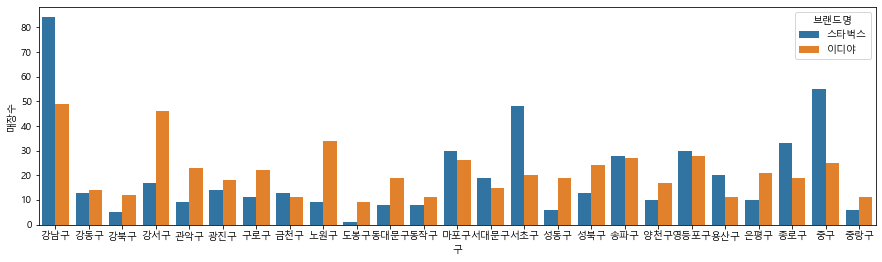

In [65]:
# seaborn의 barplot 을 활용해 구별 매장수를 시각화 합니다.
plt.figure(figsize=(15,4))
sns.barplot(data=group, x='구', y='매장수', hue='브랜드명')

## 브랜드, 구별 매장수

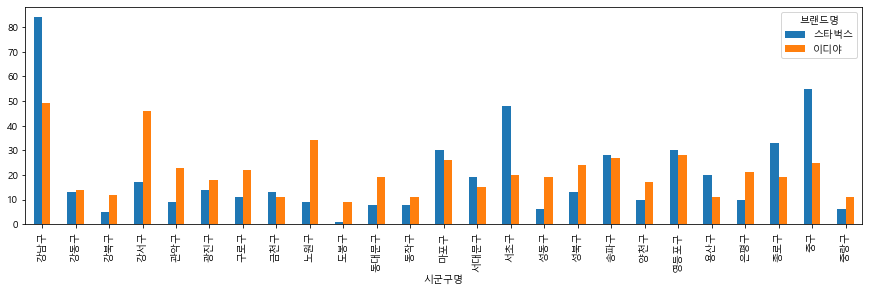

In [66]:
# groupby 를 통해 "시군구명"으로 그룹화를 하고 "상호명"의 갯수를 세어봅니다.
# 갯수를 셀때는 count를 사용합니다.

df_cafe.groupby(['시군구명', '브랜드명'])['상호명'].count().unstack().plot.bar(figsize=(15,4))

In [67]:
# pivot_table 을 이용해서 구별 스타벅스, 이디야 매장수를 구합니다.

df_cafe.pivot_table(index='시군구명', columns='브랜드명', values='상호명',aggfunc='count')

브랜드명,스타벅스,이디야
시군구명,,
강남구,84,49
강동구,13,14
강북구,5,12
강서구,17,46
관악구,9,23
광진구,14,18
구로구,11,22
금천구,13,11
노원구,9,34


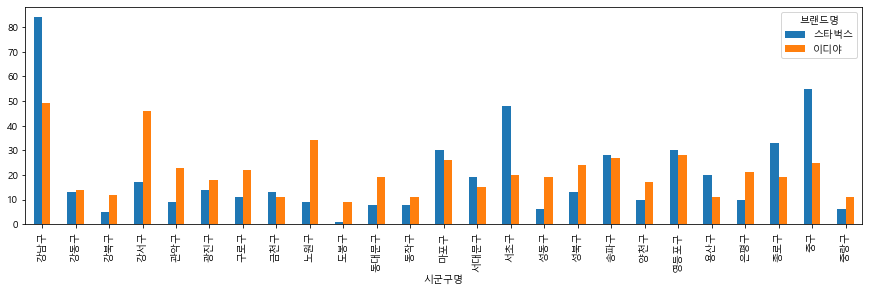

In [68]:
# 판다스의 장점 중 하나는 위에서처럼 구한 pivot_table을 시각화 해보기 쉽습니다.
# pivot_table 로 구한 결과를 plot.bar()를 통해 시각화 합니다.

df_cafe.pivot_table(index='시군구명', columns='브랜드명', values='상호명',aggfunc='count').plot.bar(figsize=(15,4))

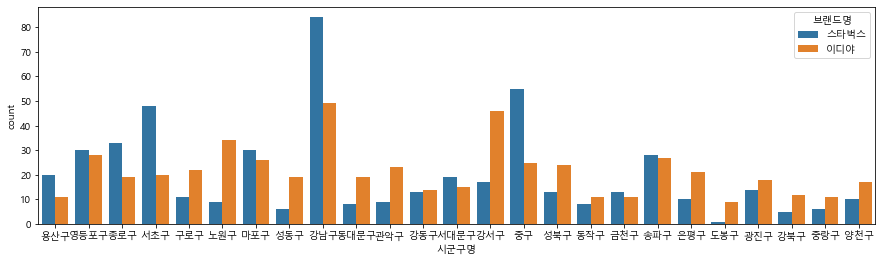

In [69]:
# Pandas 로 시각화를 하는 방법도 있지만 seaborn의 countplot을 사용하면 해당 컬럼의 수를 계산해서 시각화를 해줍니다.
# hue 옵션을 사용하게 되면 값에 따라 다른 색상으로 그리게 됩니다. 
# hue 옵션을 사용할 때는 2~3개 정도의 카테고리 형태의 데이터를 사용하는 것이 적합합니다.
# 여기에서는 브랜드명에 따라 다른 색상으로 표시할 수 있도록 합니다.
plt.figure(figsize=(15,4))
sns.countplot(data=df_cafe,x='시군구명',hue='브랜드명')

## Folium 사용예제
http://nbviewer.jupyter.org/github/python-visualization/folium/tree/master/examples/

## Folium 으로 지도 활용하기
* 다음의 프롬프트 창을 열어 conda 명령어로 설치합니다.
<img src="https://t1.daumcdn.net/cfile/tistory/99576B4A5B751DC902">

In [70]:
# 아나콘다에서 folium 을 사용하기 위해서는 별도의 설치가 필요
# https://anaconda.org/conda-forge/folium
# conda install -c conda-forge folium 
# 지도 시각화를 위한 라이브러리

import folium

* 다음의 문서를 활용해서 지도를 표현합니다.
* https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/Quickstart.ipynb

In [71]:
# 지도의 중심을 지정하기 위해 위도와 경도의 평균을 구합니다. 
lat = df_cafe['위도'].mean()
long = df_cafe['경도'].mean()
lat, long

(37.543293122474296, 126.98874792654419)

In [72]:
df_cafe.head(1)

,상가업소번호,상호명,상권업종대분류명,상권업종중분류명,상권업종소분류명,시도코드,시도명,시군구코드,시군구명,행정동명,...,대지구분명,지번본번지,지번주소,도로명주소,구우편번호,신우편번호,경도,위도,상호명_소문자,브랜드명
1219,19976038,스타벅스,음식,커피점/카페,커피전문점/카페/다방,11,서울특별시,11170,용산구,이태원1동,...,대지,127,서울특별시 용산구 이태원동 127-6,서울특별시 용산구 이태원로 188,140200,4406.0,126.994781,37.534303,스타벅스,스타벅스


In [73]:
map = folium.Map(location=[lat,long],zoom_start=11)

folium.Marker([37.534303,126.994781], tooltip='서울특별시 용산구 이태원동 127-6').add_to(map)
map

In [74]:
map = folium.Map(location=[lat,long],zoom_start=11)

for n in df_cafe.index:
    tooltip = f"{df_cafe.loc[n,'상호명']} : {df_cafe.loc[n,'도로명주소']}"
    lat = df_cafe.loc[n, '위도']
    long = df_cafe.loc[n, '경도']
    icon_color = 'green'
    
    if df_cafe.loc[n,'브랜드명'] == '이디야':
        icon_color = 'blue'
        
    folium.CircleMarker([lat,long],
                    radius = 3,
                    color = icon_color,
                    tooltip=tooltip
                   ).add_to(map)
    
map

In [75]:
map = folium.Map(location=[lat,long],zoom_start=11)

folium.CircleMarker([37.534303,126.994781],
                    radius = 5,
                    color = 'green',
                    tooltip='서울특별시 용산구 이태원동 127-6'
                   ).add_to(map)
map

## choropleth 그리기

* 구별로 매장수를 표현하기 위해 GeoJSON 파일 로드
    * 파일출처 : [southkorea/seoul-maps: Seoul administrative divisions in ESRI Shapefile, GeoJSON and TopoJSON formats.](https://github.com/southkorea/seoul-maps)
    * 이 링크에서도 다운로드가 가능합니다. https://drive.google.com/open?id=13j8-_XLdPe0pptsqu8-uyE-0Ym6V2jw5

In [2]:
# 서울의 행정구역 경계를 GeoJSON으로 표현한 파일입니다. 
# 이 파일을 불러와 구별 스타벅스와 이디야의 매장수를 표현합니다.
geo_path = 'data/seoul_municipalities_geo_simple.json'

import json
geo_json = json.load(open(geo_path, encoding='utf-8'))
geo_json["features"][0]['properties']['name']

'강동구'

In [3]:
geo_json

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'code': '11250',
    'name': '강동구',
    'name_eng': 'Gangdong-gu',
    'base_year': '2013'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[127.11519584981606, 37.557533180704915],
      [127.11879551821994, 37.557222485451305],
      [127.12146867175024, 37.55986003393365],
      [127.12435254630417, 37.56144246249796],
      [127.13593925898998, 37.56564793048277],
      [127.14930548011061, 37.56892250303897],
      [127.15511020940411, 37.57093642128295],
      [127.16683184366129, 37.57672487388627],
      [127.17038810813094, 37.576465605301046],
      [127.17607118428914, 37.57678573961056],
      [127.17905504160184, 37.57791388161732],
      [127.17747787800164, 37.57448983055031],
      [127.1781775408844, 37.571481967974336],
      [127.17995281860672, 37.569309661290504],
      [127.18122821955262, 37.56636089217979],
      [127.18169407550688, 37.56286338914073],
      [127.18408792

### 스타벅스 이디야 카페 매장 합계 분포

In [77]:
# 지도의 중심을 지정하기 위해 위도와 경도의 평균을 구합니다. 

### 스타벅스 매장 분포

In [78]:
# 스타벅스의 매장 수를 구합니다.
# "브랜드명"컬럼으로 스타벅스만 가져옵니다.
# 또, groupby 를 통해 "시군구명"을 그룹화 해주고 "상호명"으로 count를 해주면 구별 매장수를 구할 수 있습니다.
df_star = group[group['브랜드명'] == '스타벅스'].copy()
df_star.head()

,구,브랜드명,매장수
0,강남구,스타벅스,84
2,강동구,스타벅스,13
4,강북구,스타벅스,5
6,강서구,스타벅스,17
8,관악구,스타벅스,9


In [79]:
geo_json["features"][0]['properties']['name']

'강동구'

In [100]:
df_cafe['브랜드명']

1219      스타벅스
1676       이디야
1946      스타벅스
2840      스타벅스
2886       이디야
          ... 
562067    스타벅스
562068    스타벅스
562381    스타벅스
563162    스타벅스
564740    스타벅스
Name: 브랜드명, Length: 1031, dtype: object

In [99]:
# df_cafe_starbucks 로 스타벅스 매장 수 구하기
# choropleth의 색상은 fill_color = 'YlGn'을 사용합니다.

map = folium.Map(location=[lat,long],zoom_start=11)

folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data=df_star,
    columns=['구','매장수'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='스타벅스 매장수'
).add_to(map)


for n in df_cafe.index:
    tooltip = f"{df_cafe.loc[n,'상호명']} : {df_cafe.loc[n,'도로명주소']}"
    lat = df_cafe.loc[n, '위도']
    long = df_cafe.loc[n, '경도']
    icon_color = 'green'
    
        if df_cafe.loc[n,'브랜드명'] == '이디야':
        icon_color = 'blue'
        
    folium.CircleMarker([lat,long],
                    radius = 3,
                    color = icon_color,
                    tooltip=tooltip
                   ).add_to(map)
    
map

IndentationError: unexpected indent (<ipython-input-99-65187cb504bf>, line 25)

### 이디야 매장 분포

In [81]:
# 이디야의 매장 수를 구합니다.
# "브랜드명"컬럼으로 이디야만 가져옵니다.
# 또, groupby 를 통해 "시군구명"을 그룹화 해주고 "상호명"으로 count를 해주면 구별 매장수를 구할 수 있습니다.

df_ediya = group[group['브랜드명']=='이디야'].copy()
df_ediya.head()

,구,브랜드명,매장수
1,강남구,이디야,49
3,강동구,이디야,14
5,강북구,이디야,12
7,강서구,이디야,46
9,관악구,이디야,23


In [84]:
map = folium.Map(location=[lat,long],zoom_start=11, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data=df_ediya,
    columns=['구','매장수'],
    key_on='feature.properties.name',
    fill_color='Blues',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='이디야 매장수'
).add_to(map)

for n in df_cafe.index:
    tooltip = f"{df_cafe.loc[n,'상호명']} : {df_cafe.loc[n,'도로명주소']}"
    lat = df_cafe.loc[n, '위도']
    long = df_cafe.loc[n, '경도']
    icon_color = 'green'
    
    if df_cafe.loc[n,'브랜드명'] == '이디야':
        icon_color = 'blue'
        
    folium.CircleMarker([lat,long],
                    radius = 3,
                    color = icon_color,
                    tooltip=tooltip
                   ).add_to(map)

map

In [86]:
map = folium.Map(location=[df_cafe['위도'].mean(), df_cafe['경도'].mean()], 
                 zoom_start=11, tiles='Stamen Toner')
map
# df_cafe_starbucks 로 스타벅스 매장 수 구하기
# choropleth의 색상은 fill_color = 'PuBu'을 사용합니다.


## 매장수 크기를 반영해 CircleMaker 그리기
### Pandas 의 reshaping data 활용하기

<img src="https://i.imgur.com/IIhU0nF.png">

* 출처 : https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf
* reshaping 관련 문서 : https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html

In [92]:
# df_cafe_brand 를 미리보기 합니다.
# pivot_table을 통해 스타벅스 이디야가 컬럼으로 오도록 만듭니다.

df_cafe_brand = group.pivot(index='구', columns='브랜드명')
df_cafe_brand.columns = ['스타벅스', '이디야']
df_cafe_brand['매장수비교'] = df_cafe_brand['스타벅스'] > df_cafe_brand['이디야']
df_cafe_brand.head(2)

,스타벅스,이디야,매장수비교
구,,,
강남구,84,49,True
강동구,13,14,False


In [94]:
# 간단한 함수를 사용해서 스타벅스가 이디야보다 매장수가 많을 때 1을 출력하도록 합니다.

df_cafe_brand['매장수비교'] = df_cafe_brand['매장수비교'].astype(int)
df_cafe_brand.head()

,스타벅스,이디야,매장수비교
구,,,
강남구,84,49,1
강동구,13,14,0
강북구,5,12,0
강서구,17,46,0
관악구,9,23,0


In [96]:
# 구를 컬럼명으로 사용하기 위해 reset_index를 합니다.

df_cafe_vs = df_cafe_brand.reset_index()
df_cafe_vs.head(2)

,구,스타벅스,이디야,매장수비교
0,강남구,84,49,1
1,강동구,13,14,0


In [98]:
map = folium.Map(location=[lat,long],zoom_start=11, tiles='Stamen Toner')

folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data=df_cafe_vs,
    columns=['구','매장수비교'],
    key_on='feature.properties.name',
    fill_color='BuGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='스타벅스 이디야 매장수 비교'
).add_to(map)

for n in df_cafe.index:
    tooltip = f"{df_cafe.loc[n,'상호명']} : {df_cafe.loc[n,'도로명주소']}"
    lat = df_cafe.loc[n, '위도']
    long = df_cafe.loc[n, '경도']
    icon_color = 'green'
    
    if df_cafe.loc[n,'브랜드명'] == '이디야':
        icon_color = 'blue'
        
    folium.CircleMarker([lat,long],
                    radius = 3,
                    color = icon_color,
                    tooltip=tooltip
                   ).add_to(map)

map

In [ ]:
# pandas 의 apply를 사용해서 매장수를 비교하는 함수를 적용해 줍니다.
# df_cafe_brand_vs를 사용합니다. 컬럼명은 "매장수비교"로 합니다. 



In [ ]:
# 위의 방법을 아래와 같은 람다표현식을 사용해서 구현할 수도 있습니다.
# 한 줄에 간결하게 표현할 수 있지만 아직은 익숙하지 않을 수 있으니 위에 방법을 먼저 해보시는 걸 추천합니다.



In [ ]:
# 구별로 CircleMarker를 표현하기 위해서는 각 구의 위경도 값을 구해야 합니다.
# 구별 위도와 경도를 가져와 평균 값을 구해서 사용합니다.



In [ ]:
# CircleMarker의 radius 지정시 다음과 같은 타입오류가 나서 float type 으로 변경합니다.
# TypeError: Object of type 'int64' is not JSON serializable




In [ ]:
#  아래의 for문을 활용해서  스타벅스, 이디야로 매장수를 반영해 그리도록 합니다.



#### 지도 출력 시 색상 참고
* http://colorbrewer2.org/

## folium 공부를 위해 더 읽어보면 좋을 것 
* https://nbviewer.jupyter.org/github/python-visualization/folium/tree/master/examples/
* https://python-visualization.github.io/folium/quickstart.html#Choropleth-maps

## 카토그램 
* [총선⑫ 인구 비례로 본 당선 지도…‘카토그램’으로 살펴본 당선 현황 > 데이터룸 > 정치 > 뉴스 | KBSNEWS](http://news.kbs.co.kr/news/view.do?ncd=3264019)
* [The Housing Value of Every County in the U.S. - Metrocosm](http://metrocosm.com/the-housing-value-of-every-county-in-the-u-s/)